# NLP and LLM-based Analysis of Student Emotion Diaries

## Load packages

In [16]:
# import moduels
import numpy as np
import pandas as pd
import re
import csv
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import json
import hashlib
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from openai import OpenAI
from neo4j_graphrag.llm import OpenAILLM
import neo4j
from neo4j_graphrag.generation.prompts import ERExtractionTemplate
from neo4j_graphrag.experimental.components.kg_writer import Neo4jWriter
from neo4j_graphrag.experimental.components.types import Neo4jGraph

import torch
os.environ["WANDB_DISABLED"] = "true"
from transformers import AutoTokenizer, AutoModelForAudioClassification, TrainingArguments, Trainer, AutoModelForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support

plt.rcParams['font.family'] = 'AppleGothic' 

## Data Preprocessing

### Digitalization - Google AI Studio

### Constructing Dataframe

In [2]:
# Open text data
with open('raw_data.txt', 'r', encoding='utf-8') as f:
    raw_text = f.read()

# Devide text by name
blocks = re.split(r'\n(?=[가-힣]{2,4}\n일기 \d+\n)',raw_text) #re.split(pattern, string)

rows = []
word = []

for block in blocks :
    word.append(str.split(block, '\n'))

# Create Dataframe
raw_data = pd.DataFrame(columns=['Name', 'Number', 'Date', 'Weather', 'Emotion', 'Diary title' ,'Diary'])

# Extract componets from each dairy entry and insert them into dataframe(raw_data)
def extract_value(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):].strip()
    return ''


for row in word:

    name = row[0]
    number = row[1]


    date = ''
    weather = ''
    emotion = ''
    title = ''
    diary_text = ''

    for text in row:
        if text.startswith('날짜:'):
            date = extract_value(text, '날짜:')
        elif text.startswith('날씨:'):
            weather = extract_value(text, '감정:')
        elif text.startswith('감정:'):
            emotion = extract_value(text, '감정:')
        elif text.startswith('제목:'):
            title = extract_value(text, '제목:')
        elif text.startswith('내용:'):
            diary_text = extract_value(text, '내용:')

    raw_data.loc[len(raw_data)] = [name, number, date, weather, emotion, title, diary_text]

### Data Privacy
- hashlib

In [3]:
## To protect data privacy, students' names have been replaced with nicknames.

# Students real name list
students_real_names = list(raw_data['Name'].unique())

# Get full name and surname
name_variants = []
for name in students_real_names:
    if len(name) > 1:
        # Full name
        name_variants.append(name)
        # First name (My students’ first names start with the initial letter of their surname.)
        name_variants.append(name[1:])
    else:
        name_variants.append(name)

#Generate nicknames using hashlib
def hash_string(input_str):
    return hashlib.sha256(input_str.encode()).hexdigest()[:7]

nicknames = [hash_string(students_real_names[i]) for i in range(len(students_real_names))]

# name - nick name mapping
nickname_map = {}
for real_name, nick in zip(students_real_names, nicknames):
    nickname_map[real_name] = nick
    if len(real_name) > 1:
        nickname_map[real_name[1:]] = nick

# nickname_map eg : {real name : nickname}


# The 'Name' and 'Diary' columns contain real names.
# Transform all real names into nicknames for privacy.

df_privacy = raw_data.copy()

# Define function
def replace_names(text):
    if pd.isna(text):
        return text
    # change serveral names using regular expressions

    # mapping dictionary
    adjusted_map = {
        ('**' if k == '*' else k): v for k, v in nickname_map.items()  #One student has one letter of lastname, so it counfused
    }

    # regular expression
    pattern = re.compile("|".join(re.escape(k) for k in adjusted_map.keys()))

    # change function
    return pattern.sub(lambda x: adjusted_map[x.group()], text)


# Diary columns
df_privacy['Diary'] = df_privacy['Diary'].apply(replace_names)

# Name coulums
df_privacy['Name'] = df_privacy['Name'].map(nickname_map).fillna(df_privacy['Name'])

In [4]:
df_privacy[11:15]

,Name,Number,Date,Weather,Emotion,Diary title,Diary
11,71db26b,일기 1,,,"행복하다, 기쁘다",그림,오늘 미술시간에 그림을 그리는데 처음 스케치할 때는 친구들이 별로 말을 안 했는데 ...
12,71db26b,일기 2,,,"즐겁다, 답답하다(다음에 또 하고 싶다)",오목,오늘은 오목을 했다. 2aa8348강 나랑 먼저 하고 다음은 826175f이랑 나랑...
13,71db26b,일기 3,2025-07-07,,"속상하다, 화나다, 억울하다, 기분이 나쁘다, 화가 부글부글한다",생존수영,오늘은 생존수영을 배웠다. 근데 dc88476이가 벽에 안 붙어서 두 번 말했는데 ...
14,71db26b,일기 4,2025-07-08,,"무섭다, 울고 싶다, 긴장하다",놀람,오늘은 새우등 뜨기랑 해파리 뜨기랑 페트병 들고 뜨기를 했는데 너무 무서워서 훌쩍이...


### Data Cleaning

In [5]:
diary = df_privacy.copy()
# Remove rows with missing emotion values by index
diary.drop(index=[8, 205, 210], inplace=True)


# For some rows with missing emotions, infer emotion from the first word of 'Diary title'
for idx in diary.iloc[190:200].index:
    diary.loc[idx, 'Emotion'] = diary.loc[idx, "Diary title"].split(" ")[0]

# diary.loc[190:199, 'Emotion'] = diary.loc[190:199, 'Diary title'].apply(lambda x: x.strip()[0])

# Reset the index to remove gaps and have consecutive numbering
diary.reset_index(drop=True, inplace=True)

In [6]:
diary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         257 non-null    object
 1   Number       257 non-null    object
 2   Date         257 non-null    object
 3   Weather      257 non-null    object
 4   Emotion      257 non-null    object
 5   Diary title  257 non-null    object
 6   Diary        257 non-null    object
dtypes: object(7)
memory usage: 14.2+ KB


In [7]:
# Peer relationships are one of the most influential factors affecting students' emotions in school life.

student_names = list(diary.Name.unique())
student_names

# Select only diary entries that contain students' names to maximize analysis efficiency
pattern = '|'.join(map(re.escape, student_names))
diary2 = diary[diary['Diary'].str.contains(pattern, na= False)]
# Only 38 diary entries left
diary2

# Change text format for Neo4j input
text_list = []
for idx, row in diary2.iterrows() :
    text_list.append(row['Name'] + " : " + row['Diary'])
text_list[10]

'dac2109 : 오늘은 4교시에 체육을 했다. 피구팀을 정했는데 2aa8348팀이 안돼서 아쉬웠지만 즐거웠다.'

In [8]:
# .env file
load_dotenv()

# API key
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

## Data analysis

In [ ]:
prompt_template = ERExtractionTemplate()
llm = OpenAILLM(model_name="gpt-4o", model_params={"temperature": 0})

graph_json = ''
graph_history = ''
for user_input in text_list + ['finish']:
    if(user_input == 'finish'):
        with neo4j.GraphDatabase.driver("bolt://44.199.251.177:7687", auth=("neo4j", 'tune-disk-rain')) as driver:
            writer = Neo4jWriter(driver)
            graph = Neo4jGraph(
                nodes= graph_json['nodes'],
                relationships= graph_json['relationships']
            )
            await writer.run(graph)
            break

    prompt = prompt_template.format(
        schema = """
        '0f368b7', '71db26b', '3a693a0', 'dac2109', 'dc88476', 'f14a686', '2aa8348', '7685386', '826175f', '1668616', '2040613', 'e0dabba',
       '58931c4', '6a4eec6', 'd43e7e4', '23de8b0', '2926bfc', '45156c0', '8fcaf23', '9909af3', '9642e41', 'ec4a490', 'a2424b0', 'd9a5b82', '6c632a1'
        These are student name
        All 25 student nodes must always appear """,
        text = user_input
            + """(Continue extracting the graph for the following Input text.
                Ensure you retain the existing nodes and relationships from the graph history
                and add only new nodes and relationships.\n
                Graph History : """ + graph_history + ")",
        examples = ''
    )

    print(prompt)
    response = llm.invoke(prompt) # Extrach graph
    print(response.content)
    graph_history = response.content

    # Sometimes the response includes ```json```, so we split based on {}
    graph_json = json.loads(graph_history[graph_history.find("{"):graph_history.rfind("}")+1])

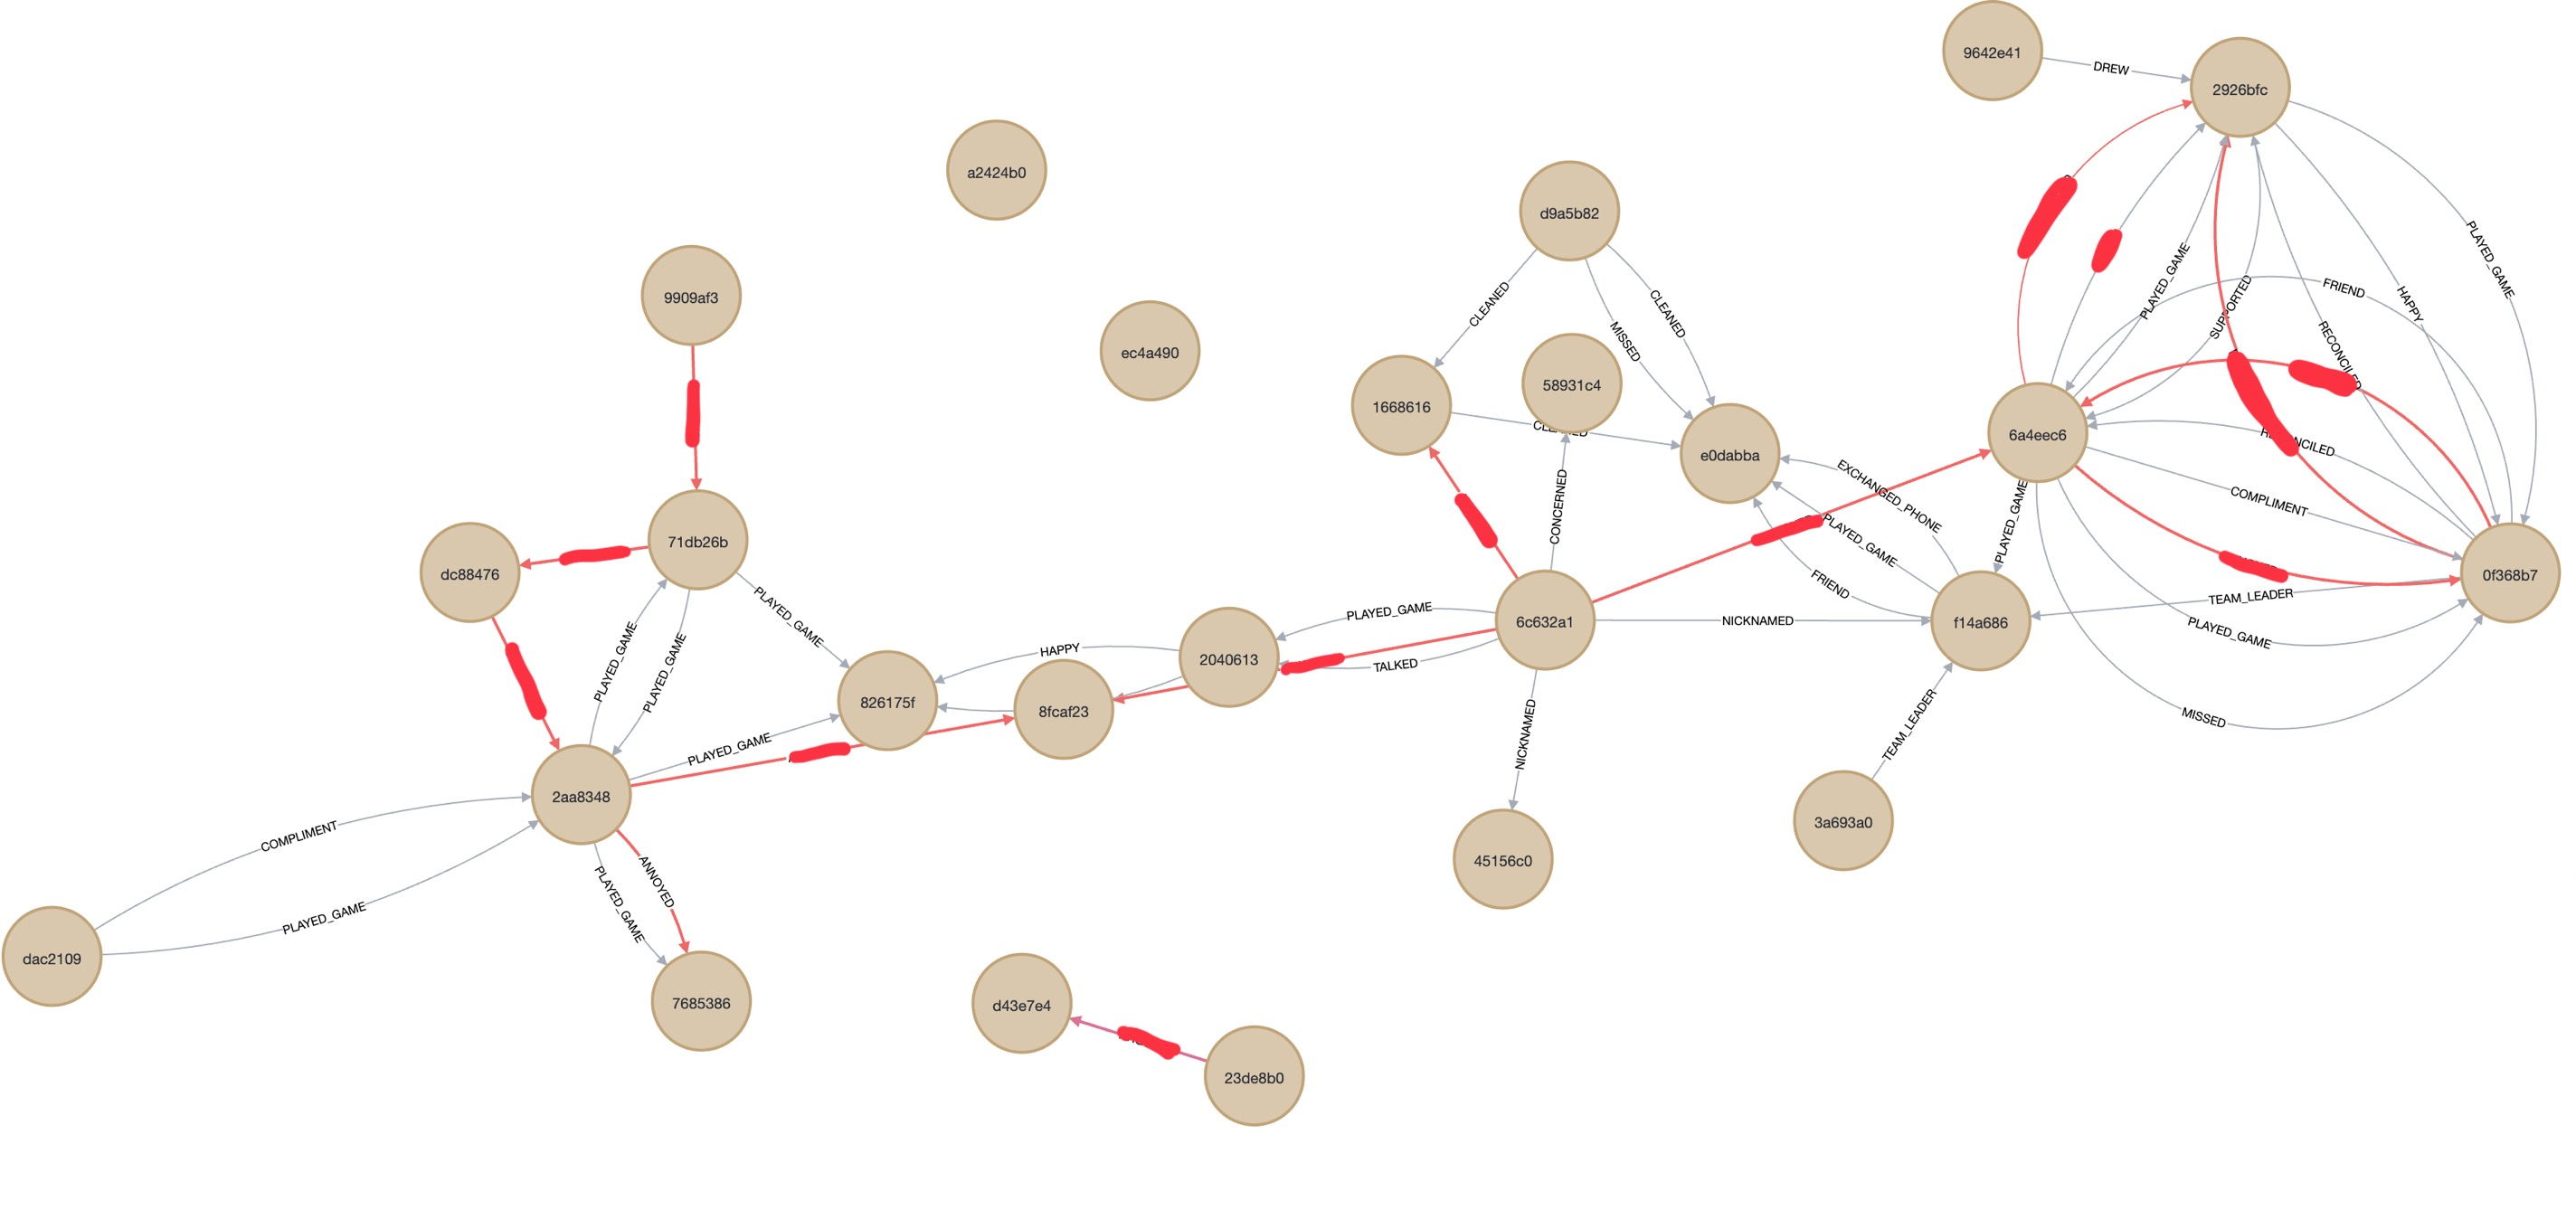

In [ ]:
# Result of Neo4j 
display(Image(filename='assets/Neo4jgraph1.jpg'))

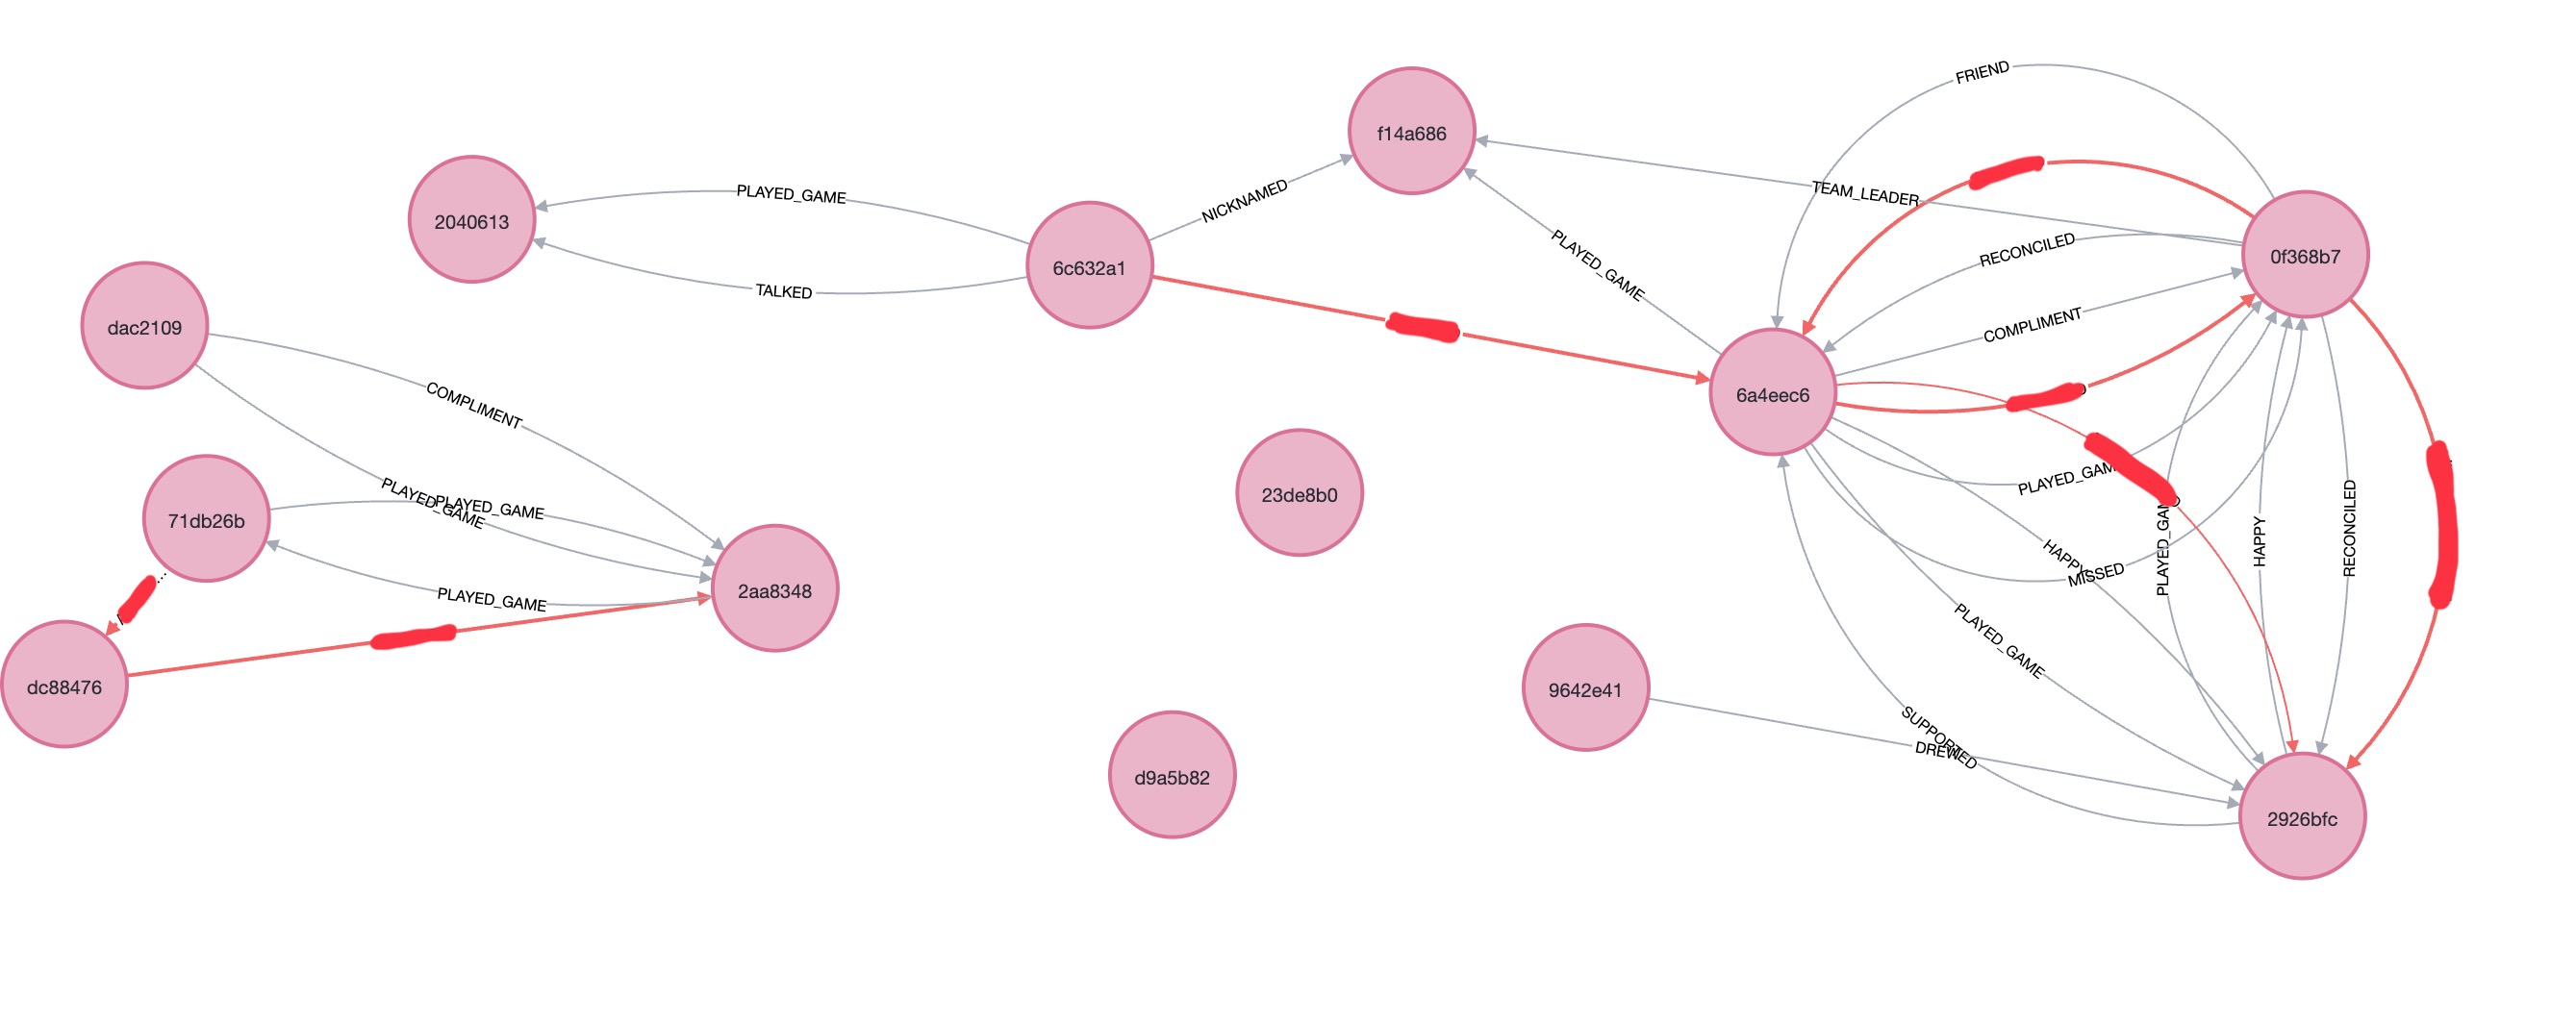

In [ ]:
# Result of Neo4j Cyper query 

"""MATCH (n:Student)
WHERE n.name IN [
'0f368b7', '71db26b', 'dac2109', 'dc88476', 'f14a686', '2aa8348',
'2040613', '6a4eec6', '23de8b0', '2926bfc', '9642e41', 'd9a5b82',
'6c632a1']
RETURN n"""

# Draw a graph for students who mentioned other students' names in their diaries
display(Image(filename='assets/Neo4graph2.jpg'))

## Modeling

### Psedo-Labeling

In [9]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="sangrimlee/bert-base-multilingual-cased-nsmc", framework='pt')

# Manually correct the mislabeled data
# negative_words dictionary
negative_words = ["슬프", "아쉽", "아쉬", "화나다", "울고", "무섭", "긴장", "귀찮", "떨리다", "아프", "외롭"]
# positive_words dictionary
positive_words = ["상상", "궁금", "신난", "뿌듯", "흐뭇", "즐겁", "신기", "소망", "감사"]
nutural_words = ["그저", "그렇다"]

# Get the scores for each emotion words
def get_score_morphs(df, tag_colname):
    all_scores = []

    for i in range(len(df)):
        sentence = df[tag_colname][i]
        score = []
        # To get the scores for each emotion word, split the text using commas
        for part in sentence.split(","):
            part_clean = part.strip()
            result = classifier(part_clean)[0]
            # If the word is in the emotion dictionary(negative), treat it as negative.
            if any(neg_word in part_clean for neg_word in negative_words):
                adjusted_score = round(-abs(result['score']), 3)

            # If the word is in the emotion dictionary(negative), treat it as negative.
            elif any(pos_word in part_clean for pos_word in positive_words):
                adjusted_score = round(abs(result['score']), 3)
            else:
                # normal
                if result['label'].lower() == 'negative':
                    adjusted_score = round(-result['score'], 3)
                else:
                    adjusted_score = round(result['score'], 3)
            score.append(adjusted_score)
        all_scores.append(score)
    return all_scores

scores = get_score_morphs(diary, "Emotion")
scores[:10]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[[0.855, 0.963],
 [0.855, 0.963],
 [-0.652, -0.614],
 [0.973, 0.96, 0.855, 0.963, 0.844],
 [-0.599, -0.912],
 [0.977, 0.96, 0.963],
 [0.973, 0.96, 0.855, 0.963],
 [0.977, 0.96, 0.855, 0.963],
 [-0.599],
 [0.963]]

In [10]:
# labeling

diary_label = diary.copy()
def label_from_scores(all_scores):
    for i in range(len(all_scores)):
        all_positive = all(n > 0 for n in all_scores[i])
        all_negative = all(n < 0 for n in all_scores[i])

        # If all words are positive, label as 1
        if all_positive :
            label = 1
        # If all words are negative, label as 0
        elif all_negative :
            label = 0
        # If positive and negative are mixed, choose the one with the higher absolute value
        else :
            max_abs_num = max(all_scores[i], key = abs)
            lable =  1 if max_abs_num > 0 else 0

        diary_label.loc[i, 'label'] = label
    return diary_label

diary_label = label_from_scores(scores)


In [11]:
diary_label[11:15]

,Name,Number,Date,Weather,Emotion,Diary title,Diary,label
11,71db26b,일기 2,,,"즐겁다, 답답하다(다음에 또 하고 싶다)",오목,오늘은 오목을 했다. 2aa8348강 나랑 먼저 하고 다음은 826175f이랑 나랑...,1.0
12,71db26b,일기 3,2025-07-07,,"속상하다, 화나다, 억울하다, 기분이 나쁘다, 화가 부글부글한다",생존수영,오늘은 생존수영을 배웠다. 근데 dc88476이가 벽에 안 붙어서 두 번 말했는데 ...,0.0
13,71db26b,일기 4,2025-07-08,,"무섭다, 울고 싶다, 긴장하다",놀람,오늘은 새우등 뜨기랑 해파리 뜨기랑 페트병 들고 뜨기를 했는데 너무 무서워서 훌쩍이...,0.0
14,71db26b,일기 5,2025-07-09,,"행복하다, 설레다, 재미있다",생존수영,"오늘은 구명조끼 배우기를 했다. 단계는 1, 2, 3, 4, 5, 6단계가 있었다....",1.0


### Sentiment Anaysis - BERT (Pretrained model VS Fine-tuned)

In [12]:
# Check the ratio
diary_label['label'].value_counts()

label
1.0    173
0.0     84
Name: count, dtype: int64

In [13]:
train_data = diary_label[['Diary', 'label']].sample(frac = 0.8, random_state = 42)
test_data = diary_label[['Diary', 'label']].drop(train_data.index)

In [17]:
# Pretrained model

# Load model
model_name = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Create pipeline(text classification)
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Classification
results = []
for idx, row in test_data.iterrows() :
    result = classifier(row['Diary'])[0].get("label")
    results.append(result)

# # Correct the label format
test_data['prediction'] = results
test_data['pre_trained_label'] = test_data['prediction'].apply(lambda x : 0 if x == 'LABEL_0' else 1)
test_data.drop(['prediction'], axis = 1)

# Evaluation
y_true = test_data['label'] #real
y_pred = test_data['pre_trained_label'] #predict

acc = accuracy_score (y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Accuracy: {acc}, F1: {f1}, Precision: {precision}, Recall: {recall}")

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Accuracy: 0.5882352941176471, F1: 0.7407407407407407, Precision: 0.5882352941176471, Recall: 1.0


In [18]:
# Fine tuning

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device :', device)

model_name = "beomi/KcELECTRA-base"

# Tokenising
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_train_sentences = tokenizer(
    list(train_data['Diary']),
    return_tensors = "pt",
    max_length = 128,
    padding = True,
    truncation = True,
    add_special_tokens = True)

tokenized_test_sentences = tokenizer(
    list(test_data['Diary']),
    return_tensors = "pt",
    max_length = 128,
    padding = True,
    truncation = True,
    add_special_tokens = True)

# Load Dataset
class CurseDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx], dtype=torch.long) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


    def __len__(self):
        return len(self.labels)

train_label= train_data["label"].values
test_label=test_data["label"].values

train_dataset = CurseDataset(tokenized_train_sentences, train_label)
test_dataset = CurseDataset(tokenized_test_sentences, test_label)

# Training
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)
model.to(device)

training_args = TrainingArguments(
    output_dir = './',
    num_train_epochs= 3,
    per_device_train_batch_size= 16,
    per_device_eval_batch_size= 64,
    logging_dir = '.logs',
    logging_steps = 5,
    save_total_limit = 2,
    report_to=["none"]
)

# Evaluation
def compute_metrics(pred) :
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _  = precision_recall_fscore_support(labels, preds, average = 'binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy_score' : acc,
        'f1': f1,
        'precision' : precision,
        'recall' : recall
    }

# Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset=train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics
)

device : cpu


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/39 [00:00<?, ?it/s]

{'loss': 0.6734, 'grad_norm': 1.3268693685531616, 'learning_rate': 4.358974358974359e-05, 'epoch': 0.38}
{'loss': 0.5843, 'grad_norm': 1.0392886400222778, 'learning_rate': 3.717948717948718e-05, 'epoch': 0.77}
{'loss': 0.5882, 'grad_norm': 2.93300724029541, 'learning_rate': 3.0769230769230774e-05, 'epoch': 1.15}
{'loss': 0.5353, 'grad_norm': 1.8883098363876343, 'learning_rate': 2.435897435897436e-05, 'epoch': 1.54}
{'loss': 0.4972, 'grad_norm': 1.7386845350265503, 'learning_rate': 1.794871794871795e-05, 'epoch': 1.92}
{'loss': 0.3966, 'grad_norm': 2.353531837463379, 'learning_rate': 1.153846153846154e-05, 'epoch': 2.31}
{'loss': 0.4649, 'grad_norm': 6.351107120513916, 'learning_rate': 5.128205128205128e-06, 'epoch': 2.69}
{'train_runtime': 24.9872, 'train_samples_per_second': 24.733, 'train_steps_per_second': 1.561, 'train_loss': 0.5166922991092389, 'epoch': 3.0}


TrainOutput(global_step=39, training_loss=0.5166922991092389, metrics={'train_runtime': 24.9872, 'train_samples_per_second': 24.733, 'train_steps_per_second': 1.561, 'total_flos': 23818744953000.0, 'train_loss': 0.5166922991092389, 'epoch': 3.0})

In [20]:
trainer.evaluate(eval_dataset = test_dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.5271451473236084,
 'eval_accuracy_score': 0.7843137254901961,
 'eval_f1': 0.835820895522388,
 'eval_precision': 0.7567567567567568,
 'eval_recall': 0.9333333333333333,
 'eval_runtime': 0.7853,
 'eval_samples_per_second': 64.945,
 'eval_steps_per_second': 1.273,
 'epoch': 3.0}

## Generating products (Prompt engineering)
- using GPT-3.5-turbo

In [ ]:
diary_LLM = diary_label.copy()

# Sentiment analysis and finding cause of the emotion

def analyze_emotion_and_cause(text):
    # 1. Sentiment analysis
    emotion_response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content":
             "Detect one or more emotions present in the input text and provide a score (e.g., from 0 to 1) indicating the intensity or confidence level for each detected emotion. "
             "Choose only from the following emotions: neutral, happy, joy, sadness, anger, worry. "
             "Example output format: {\"happy\": 0.8 , \"worry\": 0.6}"},
            {"role": "user", "content": text}
        ]
    )
    emotion_text = emotion_response.choices[0].message.content.strip()

    try:
        # Parsing with dictionary
        emotion_dict = json.loads(emotion_text)
    except:
        print("Emotion parsing error:", emotion_text)
        return {}, {}

    # 2. Finding cause of the emotion
    cause_prompt = f"""
    Given the following sentence and detected emotions, explain the cause for each emotion.
    Sentence: "{text}"
    Detected Emotions: {emotion_dict}

    Format your answer as a JSON dictionary mapping each emotion to its cause. Don't forget comma in JSON dictionary
    Example:

   {{"happy": "being able to play with Student14", "worry": "not being able to play with Student14"}}
    Answer in English only.
    """
    cause_response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": cause_prompt}
        ]
    )
    cause_text = cause_response.choices[0].message.content.strip()

    try:
        cause_dict = json.loads(cause_text)
    except:
        print("Cause parsing error:", cause_text)
        return emotion_dict, {}

    return emotion_dict, cause_dict

In [ ]:
# Make 'emotion' and 'emotion_cause' columns in the dataframe
emotion_results = []
cause_results = []
#
for diary_text in diary_LLM['Diary']:
    try:
        emotion, cause = analyze_emotion_and_cause(diary_text)
    except Exception as e:
        emotion, cause = "error", str(e)

    emotion_results.append(emotion)
    cause_results.append(cause)

#
diary_LLM['emotion'] = emotion_results
diary_LLM['emotion_cause'] = cause_results

In [30]:
diary_LLM[11:15]

,Name,Number,Date,Weather,Emotion,Diary_title,Diary,label,emotion,emotion_cause
11,753e216,일기 2,NaN,NaN,"즐겁다, 답답하다(다음에 또 하고 싶다)",오목,오늘은 오목을 했다. 8a2b9ef강 나랑 먼저 하고 다음은 91ab0aa이랑 나랑...,1.0,{'neutral': 1.0},"{'neutral': ""The speaker is describing a serie..."
12,753e216,일기 3,2025-07-07,NaN,"속상하다, 화나다, 억울하다, 기분이 나쁘다, 화가 부글부글한다",생존수영,오늘은 생존수영을 배웠다. 근데 6ee5fe2이가 벽에 안 붙어서 두 번 말했는데 ...,0.0,"{'anger': 0.8, 'sadness': 0.7, 'worry': 0.4}","{'anger': ""Feeling frustrated because the pers..."
13,753e216,일기 4,2025-07-08,NaN,"무섭다, 울고 싶다, 긴장하다",놀람,오늘은 새우등 뜨기랑 해파리 뜨기랑 페트병 들고 뜨기를 했는데 너무 무서워서 훌쩍이...,0.0,"{'worry': 0.9, 'sadness': 0.7}",{'worry': 'The cause of worry in the sentence ...
14,753e216,일기 5,2025-07-09,NaN,"행복하다, 설레다, 재미있다",생존수영,"오늘은 구명조끼 배우기를 했다. 단계는 1, 2, 3, 4, 5, 6단계가 있었다....",1.0,"{'neutral': 0.9, 'joy': 0.2, 'worry': 0.4}",{'neutral': 'Learning how to wear a life jacke...


In [31]:
diary_LLM2 = diary_LLM.copy()

# Ready for adding emotion scores

columns = ['neutral', 'happy', 'joy', 'sadness', 'anger', 'worry']
zero = pd.DataFrame(0, index=range(257), columns=columns)

diary_LLM2 = pd.concat([diary_LLM2, zero],  axis = 1)


# Fill in the value if the corresponding key exists in the emotion dictionary for each emotion.
emotion_keys = ['happy', 'worry', 'joy', 'sadness', 'anger', 'neutral']

for key in emotion_keys:
    diary_LLM2[key] = diary_LLM2.apply(lambda row: row['emotion'].get(key) if pd.notnull(row['emotion']) and isinstance(row['emotion'], dict) else None, axis=1)

# Fillna
diary_LLM2[['happy', 'worry', 'joy', 'sadness', 'anger', 'neutral']] = \
    diary_LLM2[['happy', 'worry', 'joy', 'sadness', 'anger', 'neutral']].fillna(0)

In [32]:
diary_LLM2[11:15]

,Name,Number,Date,Weather,Emotion,Diary_title,Diary,label,emotion,emotion_cause,neutral,happy,joy,sadness,anger,worry
11,753e216,일기 2,NaN,NaN,"즐겁다, 답답하다(다음에 또 하고 싶다)",오목,오늘은 오목을 했다. 8a2b9ef강 나랑 먼저 하고 다음은 91ab0aa이랑 나랑...,1.0,{'neutral': 1.0},"{'neutral': ""The speaker is describing a serie...",0,0,0,0,0,0
12,753e216,일기 3,2025-07-07,NaN,"속상하다, 화나다, 억울하다, 기분이 나쁘다, 화가 부글부글한다",생존수영,오늘은 생존수영을 배웠다. 근데 6ee5fe2이가 벽에 안 붙어서 두 번 말했는데 ...,0.0,"{'anger': 0.8, 'sadness': 0.7, 'worry': 0.4}","{'anger': ""Feeling frustrated because the pers...",0,0,0,0,0,0
13,753e216,일기 4,2025-07-08,NaN,"무섭다, 울고 싶다, 긴장하다",놀람,오늘은 새우등 뜨기랑 해파리 뜨기랑 페트병 들고 뜨기를 했는데 너무 무서워서 훌쩍이...,0.0,"{'worry': 0.9, 'sadness': 0.7}",{'worry': 'The cause of worry in the sentence ...,0,0,0,0,0,0
14,753e216,일기 5,2025-07-09,NaN,"행복하다, 설레다, 재미있다",생존수영,"오늘은 구명조끼 배우기를 했다. 단계는 1, 2, 3, 4, 5, 6단계가 있었다....",1.0,"{'neutral': 0.9, 'joy': 0.2, 'worry': 0.4}",{'neutral': 'Learning how to wear a life jacke...,0,0,0,0,0,0


In [33]:
diary_LLM2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           257 non-null    object 
 1   Number         257 non-null    object 
 2   Date           208 non-null    object 
 3   Weather        0 non-null      float64
 4   Emotion        257 non-null    object 
 5   Diary_title    159 non-null    object 
 6   Diary          257 non-null    object 
 7   label          257 non-null    float64
 8   emotion        257 non-null    object 
 9   emotion_cause  257 non-null    object 
 10  neutral        257 non-null    int64  
 11  happy          257 non-null    int64  
 12  joy            257 non-null    int64  
 13  sadness        257 non-null    int64  
 14  anger          257 non-null    int64  
 15  worry          257 non-null    int64  
dtypes: float64(2), int64(6), object(8)
memory usage: 32.3+ KB


In [ ]:
# Create dominant emotion dataframe
diary_LLM3 = diary_LLM2.copy()
emotion_cols = ["neutral", "happy", "joy", "anger", "sadness", "worry"]

diary_LLM3["dominant_emotion"] = diary_LLM3[emotion_cols].idxmax(axis=1)  
diary_LLM3["dominant_score"] = diary_LLM3[emotion_cols].max(axis=1) 
diary_LLM3

In [4]:
import pandas  as pd

In [ ]:
# Create dominant emotion dataframe -> generate emotion calendar
diary_LLM3 = diary_LLM2.copy()
emotion_cols = ["neutral", "happy", "joy", "anger", "sadness", "worry"]

diary_LLM3["dominant_emotion"] = diary_LLM3[emotion_cols].idxmax(axis=1)  
diary_LLM3["dominant_score"] = diary_LLM3[emotion_cols].max(axis=1) 
diary_LLM3[11:15]

,Name,Number,Date,Weather,Emotion,Diary_title,Diary,label,emotion,emotion_cause,neutral,happy,joy,sadness,anger,worry,dominant_emotion,dominant_score
11,753e216,일기 2,NaN,NaN,"즐겁다, 답답하다(다음에 또 하고 싶다)",오목,오늘은 오목을 했다. 8a2b9ef강 나랑 먼저 하고 다음은 91ab0aa이랑 나랑...,1.0,{'neutral': 1.0},"{'neutral': ""The speaker is describing a serie...",1.0,0.0,0.0,0.0,0.0,0.0,neutral,1.0
12,753e216,일기 3,2025-07-07,NaN,"속상하다, 화나다, 억울하다, 기분이 나쁘다, 화가 부글부글한다",생존수영,오늘은 생존수영을 배웠다. 근데 6ee5fe2이가 벽에 안 붙어서 두 번 말했는데 ...,0.0,"{'anger': 0.8, 'sadness': 0.7, 'worry': 0.4}","{'anger': ""Feeling frustrated because the pers...",0.0,0.0,0.0,0.7,0.8,0.4,anger,0.8
13,753e216,일기 4,2025-07-08,NaN,"무섭다, 울고 싶다, 긴장하다",놀람,오늘은 새우등 뜨기랑 해파리 뜨기랑 페트병 들고 뜨기를 했는데 너무 무서워서 훌쩍이...,0.0,"{'worry': 0.9, 'sadness': 0.7}",{'worry': 'The cause of worry in the sentence ...,0.0,0.0,0.0,0.7,0.0,0.9,worry,0.9
14,753e216,일기 5,2025-07-09,NaN,"행복하다, 설레다, 재미있다",생존수영,"오늘은 구명조끼 배우기를 했다. 단계는 1, 2, 3, 4, 5, 6단계가 있었다....",1.0,"{'neutral': 0.9, 'joy': 0.2, 'worry': 0.4}",{'neutral': 'Learning how to wear a life jacke...,0.9,0.0,0.2,0.0,0.0,0.4,neutral,0.9


In [7]:
diary_LLM3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              257 non-null    object 
 1   Number            257 non-null    object 
 2   Date              208 non-null    object 
 3   Weather           0 non-null      float64
 4   Emotion           257 non-null    object 
 5   Diary_title       159 non-null    object 
 6   Diary             257 non-null    object 
 7   label             257 non-null    float64
 8   emotion           257 non-null    object 
 9   emotion_cause     257 non-null    object 
 10  neutral           257 non-null    float64
 11  happy             257 non-null    float64
 12  joy               257 non-null    float64
 13  sadness           257 non-null    float64
 14  anger             257 non-null    float64
 15  worry             257 non-null    float64
 16  dominant_emotion  257 non-null    object 
 1

In [ ]:
# Drop rows with missing 'Date' -> generate emotion graph
diary_LLM4 = diary_LLM3[diary_LLM3['Date'].notnull()]
diary_LLM4
diary_LLM4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              208 non-null    object 
 1   Number            208 non-null    object 
 2   Date              208 non-null    object 
 3   Weather           0 non-null      float64
 4   Emotion           208 non-null    object 
 5   Diary_title       146 non-null    object 
 6   Diary             208 non-null    object 
 7   label             208 non-null    float64
 8   emotion           208 non-null    object 
 9   emotion_cause     208 non-null    object 
 10  neutral           208 non-null    float64
 11  happy             208 non-null    float64
 12  joy               208 non-null    float64
 13  sadness           208 non-null    float64
 14  anger             208 non-null    float64
 15  worry             208 non-null    float64
 16  dominant_emotion  208 non-null    object 
 1

## Emotion Calendar - Visualization(Streamlit)